In [ ]:
###### Importing libraries ####################
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import math
import scipy.io as sio
import time
from matplotlib import cm
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.lines as mlines

############################ Defining general variables ######################################################################
T=600 #running time in days
prom=100 # averages

########## Defining maps to use #######################################
mapa='Argentina'   # opciones: 'Argentina', 'Spain', 'Mexico'

if mapa=='Argentina':
    map=0
    ##############################  ARGENTINA  MAP ######################################################################
    path1="densK7_Arg.csv"
    path2="mob275-523_Arg.csv"
    eta=float(0.00001)
    Z=0.9973 # survival parameter
    mu=1/77/365# Inverse of life expectancy in days
    umbral1= 0.10 # density threshold for cities connected by routes.

### density filter
densfilt=0

ro1=np.loadtxt(path1, delimiter=',')
nut2=np.loadtxt(path2,delimiter=',')

###################################################### Epidemiological Parameters ##################################################
beta=0.91 # Transmission paramter
sigma=14 # infectious period
epsilon=1 # latency period
omega=140 # natural inmmunity period

############################################################## auxiliary variables ############################################################
maxro=np.max(ro1)
f,g=np.where(ro1==maxro) # maximum density coordinates
ro=ro1/maxro # Normalized density
Q,P=ro.shape
nut1=nut2

if map==0:
    p=0.1
    al=5
elif map==1:
    p=0.2
    al=5
elif map==2:
    p=0.08
    al=7

###################################################### Density filter ##############################################################
if densfilt==0:
   u11=0
elif densfilt==1:
   if map==0:
     u11=0.1
   elif map==1:
     u11=0.03
   elif map==2:
     u11=0.023
O=np.copy(ro)
O[O<u11]=0
O[O>=u11]=1

#################################################### Mobility vectors ######################################################################
if map==0:
   # ventanas cada 20 días hasta 600
   tint = np.arange(0, T+1, 20)

   # deben tener longitud len(tint)-1 = 30
   a = np.array([
       0.9777, 0.0781, 0.1920, 0.1464, 0.3573, 0.4077,
       0.2367, 0.5571, 0.4505, 0.4430, 0.3502, 0.3971,
       0.3015, 0.5060, 0.3842, 0.4576, 0.4105, 0.5526,
       0.7840, 0.9781, 0.8443, 0.9976, 0.6986, 0.6556,
       0.7680, 0.4934, 0.4964, 0.6210, 0.8123, 0.9342
   ])

   rui = np.array([
       0.1986, 0.0851, 0.0816, 0.1832, 0.0507, 0.0806,
       0.0950, 0.0925, 0.0507, 0.0103, 0.0850, 0.0964,
       0.1963, 0.1942, 0.0224, 0.0895, 0.0749, 0.0870,
       0.1996, 0.1470, 0.0700, 0.1698, 0.1966, 0.1531,
       0.0156, 0.1653, 0.0845, 0.0912, 0.1420, 0.1788
   ])

   # construir vectores de 600 días
   nutm1 = []
   KT = []
   for i in range(len(tint)-1):
       nutm1 += [a[i]] * (tint[i+1]-tint[i])
       KT    += [rui[i]] * (tint[i+1]-tint[i])
   nutm1 = np.array(nutm1, dtype='float64')
   KT = np.array(KT, dtype='float64')

nutm=nutm1
nutl=nutm1

############################################################## routes matrix ############################################################
rut=np.array(0)
WW3=np.array(np.where(ro>=umbral1)) # only connecting big cities (above threshold)

for i,j in np.nditer(WW3, flags=['external_loop'], order='F'):
   if nut1[i,j]==1:
      rut=np.append(rut,[i,j])
rut=rut[1:]
rut1 = np.arange(len(rut)).reshape(2,int(len(rut)/2))
for i in range(int(len(rut)/2)):
  rut1[0,i]=rut[2*i]
  rut1[1,i]=rut[2*i+1]

rut2= (ro>=umbral1) & (nut1==1)

############################################################## Noise matrix ############################################################
filt1=(ro>0) & (ro<=1) # cells where noise can create new virus foci

################################################# Memory allocation for arrays ############################################################
V2=np.zeros((T,prom),dtype='float')
yym=np.zeros((T,prom),dtype='float')

#################################################################### Intial conditions ######################################
def cond():
  II=np.zeros((Q,P,T),dtype='float')
  S=np.ones((Q,P,T),dtype='float')
  M=np.zeros((Q,P,T),dtype='float')
  if map==0:
      II[f-4,g-4,0]= eta
      S[f-4,g-4,0]=1-eta
  elif map==1:
      II[f-4,g-5,0]= eta
      S[f-4,g-5,0]=1-eta
  elif map==2:
      II[f-2,g-1,0]= eta
      S[f-2,g-1,0]=1-eta
  return S,II,M

############################################################# Incidence function ##########################################################
def G(t,II,S,beta,filt3,ro,U): #Función de incidencia
    if t>=0:
       gg=U[filt3,t]*ro[filt3]*(1-np.exp(-beta*(II[filt3,t])))*S[filt3,t]
    elif t<0:
       g1=np.zeros((Q,P))
       gg=g1[filt3]
    return gg

################################################ Simulation ##################################################
start_time = time.time()
for pp in range(prom): ##### LOOP DE PROMEDIACION
        print('average ' + str(pp+1)+' of ' + str(prom))
        S,II,M=cond()
        rando= np.random.random(size=(Q,P,T))
        for t in range (T-1):
            M[:,:,t]= (rando[:,:,t]<nutl[t])
        U=M.astype(float) ##### MATRIZ DE ESTOCASTICA LOCAL
        for t in range(T-1):  ###### Loop temporal
          filt3= (S[:,:,t+1]==1) & (S[:,:,t]<1) & (ro>0) # FILTRO SOBRE QUE CELDAS EVOLUCIONA
          if map==2:
                if t<174:
                  p=0.08
                elif t>=174:
                  p=0.1
          elif map==1:
                if t<330:
                  p=0.2
                elif t>=330:
                  p=0.3

          # SEIQR model equations (without vaccination)
          S[filt3,t+1]=mu +(1-mu)*(S[filt3,t]-G(t,II,S,beta,filt3,ro,U)
              +G(t-1-epsilon-sigma-omega,II,S,beta,filt3,ro,U)*Z*((1-mu)**(epsilon+sigma+omega)))
          II[filt3,t+1]=(1-mu)*(II[filt3,t]+((1-mu)**(epsilon))*G(t-1-epsilon,II,S,beta,filt3,ro,U)
              -((1-mu)**(epsilon+sigma))*G(t-1-epsilon-sigma,II,S,beta,filt3,ro,U)*(1-p)
              -p*((1-mu)**(epsilon +al))*G(t-1-epsilon-al,II,S,beta,filt3,ro,U))

          ###################  Moving to neighbor cells ############################
          filt5=(ro>0) & (II[:,:,t]>=eta) & (S[:,:,t]<=1-eta)
          filt6= filt5.astype(float)
          auxil=np.zeros((Q,P))
          auxil2=np.random.random((Q,P))<nutm[t]
          auxil2=auxil2.astype(float)
          auxil[0:Q-1,:]=filt6[1:Q,:]
          auxil[1:Q,:]=auxil[1:Q,:]+filt6[0:Q-1,:]
          auxil[:,0:P-1]=auxil[:,0:P-1]+filt6[:,1:P]
          auxil[:,1:P]=auxil[:,1:P]+filt6[:,0:P-1]
          auxil[auxil>1]=1
          auxil3=auxil2*auxil
          auxil3=auxil3.astype(bool)
          filt7=(II[:,:,t]<=0) & (S[:,:,t+1]==1) & (II[:,:,t+1]==0) & (auxil3) & (ro>0)
          II[filt7,t+1]=eta
          S[filt7,t+1]=1-eta

          ###################  Moving to distant cells ############################
          for m,n in np.nditer(rut1, flags=['external_loop'], order='F'):
           if II[m,n,t]>=eta:
             for v,b in np.nditer(rut1, flags=['external_loop'], order='F'):
                             d1=np.sqrt((m-v)**2 + (n-b)**2) +.000000000001
                             nu=nutm1[t]*ro[m,n]*ro[v,b]
                             if (II[v,b,t]<=0) & (S[v,b,t+1]==0) & (S[v,b,t+1]==1) & (d1>7) and (random.random()<nu):
                                        II[v,b,t+1]=eta
                                        S[v,b,t+1]=1-eta

          ###################  Starting new foci using noise #############################
          rando2=np.random.random(size=(Q,P))
          U2=rando2< float(math.exp(-1/(KT[t])))
          U2=U2.astype(float)
          U2=U2*eta
          filt2= (II[:,:,t]<eta) & (II[:,:,t+1]<=0) & (S[:,:,t+1]>=eta) & (filt1)
          U3=U2[filt2]
          II[filt2,t+1]=U3
          S[filt2,t+1]=S[filt2,t+1]-U3

          ########  Creating time vectors #####################################
          filtn=(II[:,:,t]>0) & (II[:,:,t+1]>0)
          if (t>=epsilon):
                A=p*((1-mu)**(epsilon+1+al))*G(t-epsilon-1-al,II,S,beta,filtn,ro,U)*ro1[filtn]
                JJ=np.sum(A[A>0])
                yym[t+1,pp]=JJ

print("--- %s seconds ---" % (time.time() - start_time))

if map==0:
    pathc="code_seiqr"+"_"+str(prom)+"T_"+str(T)+"_yym_ARG.mat"
elif map==1:
    pathc="code_seiqr"+"_"+str(prom)+"T_"+str(T)+"_yym_SPA.mat"
elif map==2:
    pathc="code_seiqr"+"_"+str(prom)+"T_"+str(T)+"_yym_Mex.mat"

sio.savemat(pathc,{"serie":yym})
print('end')


average 1 of 50
average 2 of 50
average 3 of 50
average 4 of 50
average 5 of 50
average 6 of 50
average 7 of 50
average 8 of 50
average 9 of 50
average 10 of 50
average 11 of 50
average 12 of 50
average 13 of 50
average 14 of 50
average 15 of 50
average 16 of 50
average 17 of 50
average 18 of 50
average 19 of 50
average 20 of 50
average 21 of 50
average 22 of 50
average 23 of 50
average 24 of 50
average 25 of 50
average 26 of 50
average 27 of 50
average 28 of 50
average 29 of 50
average 30 of 50
average 31 of 50
average 32 of 50
average 33 of 50
average 34 of 50
average 35 of 50
average 36 of 50
average 37 of 50
average 38 of 50
average 39 of 50
average 40 of 50
average 41 of 50
average 42 of 50
average 43 of 50
average 44 of 50
average 45 of 50
average 46 of 50
average 47 of 50
average 48 of 50
average 49 of 50
average 50 of 50
--- 1893.9276506900787 seconds ---
end


In [ ]:
import pandas as pd

# Cargar datos reales desde el CSV
datos_reales = pd.read_csv("/content/Covid19arData - historico.csv",
                           parse_dates=['fecha'], dayfirst=True)

# Eliminar filas duplicadas (manteniendo el primer registro por fecha)
datos_reales = datos_reales.drop_duplicates(subset='fecha').sort_values('fecha')

# Verificar
print("Total de días únicos después de eliminar duplicados:", len(datos_reales))
print(datos_reales.head())


Total de días únicos después de eliminar duplicados: 618
       fecha  dia_inicio  dia_cuarentena_dnu260 osm_admin_level_2  \
0 2020-03-02           1                    NaN         Argentina   
1 2020-03-03           2                    NaN         Argentina   
2 2020-03-04           3                    NaN         Argentina   
3 2020-03-05           4                    NaN         Argentina   
4 2020-03-06           5                    NaN         Argentina   

  osm_admin_level_4 osm_admin_level_8  tot_casosconf  nue_casosconf_diff  \
0              CABA               NaN              1                 1.0   
1     Indeterminado               NaN              1                 0.0   
2     Indeterminado               NaN              1                 0.0   
3      Buenos Aires               NaN              2                 1.0   
4     Indeterminado               NaN              2                 0.0   

   tot_fallecidos  nue_fallecidos_diff tot_recuperados tot_terapia  \
0

In [ ]:
# Definir rango objetivo (600 días desde 2020-03-02)
rango_600d = pd.date_range(
    start=pd.to_datetime('2020-03-02'),  # Primera fecha disponible
    periods=600,
    freq='D'
)

# Alinear datos reales con el rango
datos_aligned = (
    datos_reales.set_index('fecha')
    .reindex(rango_600d)  # Ahora no habrá error de duplicados
    .reset_index()
    .rename(columns={'index': 'fecha'})
)

# Rellenar valores NaN con 0 (días sin reporte)
datos_aligned['nue_casosconf_diff'] = datos_aligned['nue_casosconf_diff'].fillna(0)

In [ ]:
print("=== Validación ===")
print(f"Datos alineados: {len(datos_aligned)} días (debe ser 600)")
print("\nPrimeras fechas:")
print(datos_aligned[['fecha', 'nue_casosconf_diff']].head())
print("\nÚltimas fechas:")
print(datos_aligned[['fecha', 'nue_casosconf_diff']].tail())
print("\nEstadísticas:")
print(datos_aligned['nue_casosconf_diff'].describe())

=== Validación ===
Datos alineados: 600 días (debe ser 600)

Primeras fechas:
       fecha  nue_casosconf_diff
0 2020-03-02                 1.0
1 2020-03-03                 0.0
2 2020-03-04                 0.0
3 2020-03-05                 1.0
4 2020-03-06                 0.0

Últimas fechas:
         fecha  nue_casosconf_diff
595 2021-10-18               354.0
596 2021-10-19               571.0
597 2021-10-20               463.0
598 2021-10-21               543.0
599 2021-10-22               525.0

Estadísticas:
count      600.000000
mean      3444.580000
std       3311.956944
min          0.000000
25%        748.250000
50%       2746.000000
75%       4950.250000
max      15550.000000
Name: nue_casosconf_diff, dtype: float64


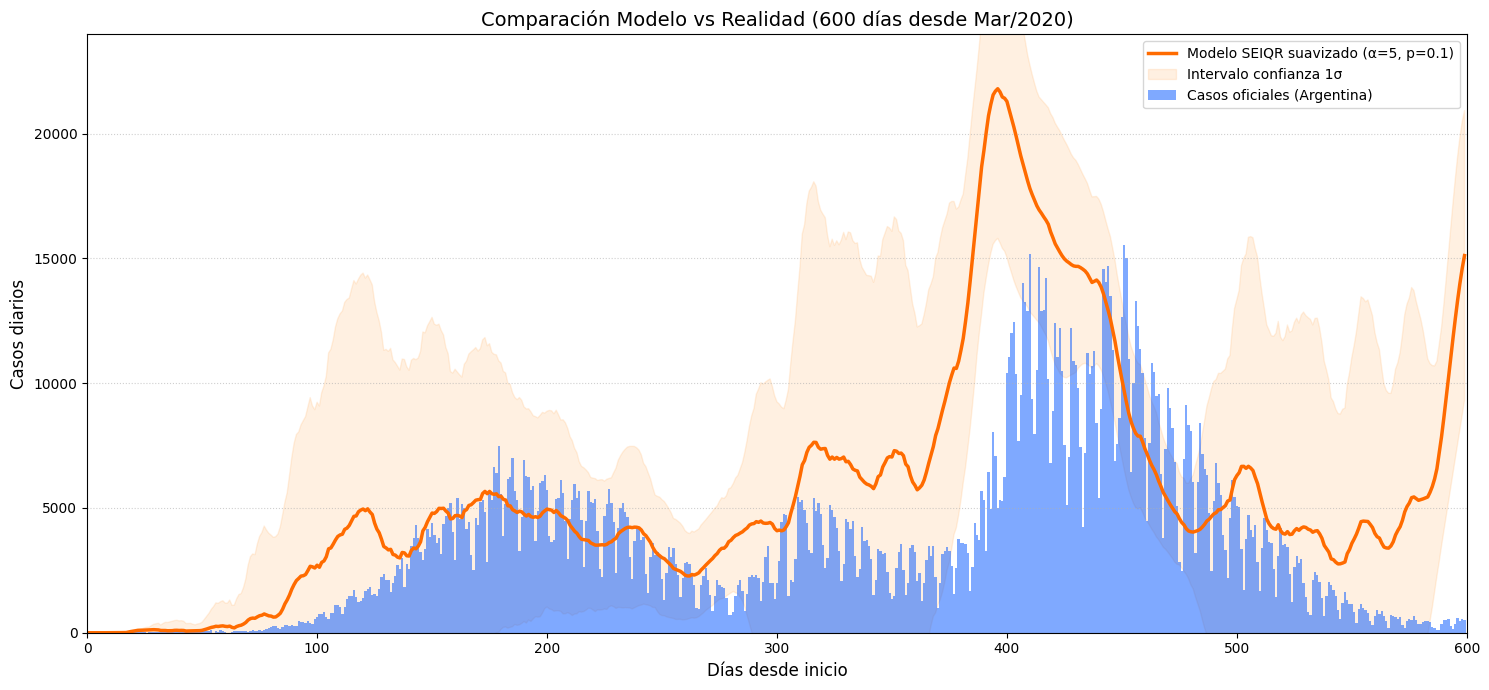

In [ ]:
# Calcular promedio y desviación estándar de las simulaciones
mean_yym = np.mean(yym, axis=1)
std_yym = np.std(yym, axis=1)

# Vector de días
days = np.arange(T)

from scipy.signal import savgol_filter

# --- Suavizado de la curva simulada ---
mean_yym_smooth = savgol_filter(mean_yym, window_length=21, polyorder=3)
std_yym_smooth = savgol_filter(std_yym, window_length=21, polyorder=3)

# Graficar
plt.figure(figsize=(15, 7))
plt.plot(days, mean_yym_smooth,
         label='Modelo SEIQR suavizado (α=5, p=0.1)',
         color='#FF6B00',
         linewidth=2.5)

plt.fill_between(days,
                 mean_yym_smooth - std_yym_smooth,
                 mean_yym_smooth + std_yym_smooth,
                 color='#FF9E3B',
                 alpha=0.15,
                 label='Intervalo confianza 1σ')

plt.bar(days, datos_aligned['nue_casosconf_diff'],
        width=1.0,
        alpha=0.5,
        color='#0055FF',
        label='Casos oficiales (Argentina)')

# Ajustes estéticos
plt.title('Comparación Modelo vs Realidad (600 días desde Mar/2020)', fontsize=14)
plt.xlabel('Días desde inicio', fontsize=12)
plt.ylabel('Casos diarios', fontsize=12)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.xlim(0, 600)
plt.ylim(0, max(mean_yym_smooth.max(),
                datos_aligned['nue_casosconf_diff'].max()) * 1.1)

plt.tight_layout()
plt.show()


In [ ]:
###### Importing libraries ####################
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import math
import scipy.io as sio
import time
from matplotlib import cm
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.lines as mlines

############################ Defining general variables ######################################################################
T=600 #running time in days
prom=100 # averages

########## Defining maps to use #######################################
mapa='Argentina'   # opciones: 'Argentina', 'Spain', 'Mexico'

if mapa=='Argentina':
    map=0
    ##############################  ARGENTINA  MAP ######################################################################
    path1="densK7_Arg.csv"
    path2="mob275-523_Arg.csv"
    eta=float(0.00001)
    Z=0.9973 # survival parameter
    mu=1/77/365# Inverse of life expectancy in days
    umbral1= 0.10 # density threshold for cities connected by routes.

### density filter
densfilt=0

ro1=np.loadtxt(path1, delimiter=',')
nut2=np.loadtxt(path2,delimiter=',')

###################################################### Epidemiological Parameters ##################################################
beta=0.91 # Transmission paramter
sigma=14 # infectious period
epsilon=1 # latency period
omega=140 # natural inmmunity period

############################################################## auxiliary variables ############################################################
maxro=np.max(ro1)
f,g=np.where(ro1==maxro) # maximum density coordinates
ro=ro1/maxro # Normalized density
Q,P=ro.shape
nut1=nut2

if map==0:
    p=0.1
    al=5
elif map==1:
    p=0.2
    al=5
elif map==2:
    p=0.08
    al=7

###################################################### Density filter ##############################################################
if densfilt==0:
   u11=0
elif densfilt==1:
   if map==0:
     u11=0.1
   elif map==1:
     u11=0.03
   elif map==2:
     u11=0.023
O=np.copy(ro)
O[O<u11]=0
O[O>=u11]=1

#################################################### Mobility vectors ######################################################################
if map==0:
   # ventanas cada 20 días hasta 600
   tint = np.arange(0, T+1, 20)

   # deben tener longitud len(tint)-1 = 30
   a = np.array([
       0.9777, 0.0781, 0.1920, 0.1464, 0.3573, 0.4077,
       0.2367, 0.5571, 0.4505, 0.4430, 0.3502, 0.3971,
       0.3015, 0.5060, 0.3842, 0.4576, 0.4105, 0.5526,
       0.7840, 0.9781, 0.8443, 0.9976, 0.6986, 0.6556,
       0.7680, 0.4934, 0.4964, 0.6210, 0.8123, 0.9342
   ])

   rui = np.array([
       0.1986, 0.0851, 0.0816, 0.1832, 0.0507, 0.0806,
       0.0950, 0.0925, 0.0507, 0.0103, 0.0850, 0.0964,
       0.1963, 0.1942, 0.0224, 0.0895, 0.0749, 0.0870,
       0.1996, 0.1470, 0.0700, 0.1698, 0.1966, 0.1531,
       0.0156, 0.1653, 0.0845, 0.0912, 0.1420, 0.1788
   ])

   # construir vectores de 600 días
   nutm1 = []
   KT = []
   for i in range(len(tint)-1):
       nutm1 += [a[i]] * (tint[i+1]-tint[i])
       KT    += [rui[i]] * (tint[i+1]-tint[i])
   nutm1 = np.array(nutm1, dtype='float64')
   KT = np.array(KT, dtype='float64')

nutm=nutm1
nutl=nutm1

############################################################## routes matrix ############################################################
rut=np.array(0)
WW3=np.array(np.where(ro>=umbral1)) # only connecting big cities (above threshold)

for i,j in np.nditer(WW3, flags=['external_loop'], order='F'):
   if nut1[i,j]==1:
      rut=np.append(rut,[i,j])
rut=rut[1:]
rut1 = np.arange(len(rut)).reshape(2,int(len(rut)/2))
for i in range(int(len(rut)/2)):
  rut1[0,i]=rut[2*i]
  rut1[1,i]=rut[2*i+1]

rut2= (ro>=umbral1) & (nut1==1)

############################################################## Noise matrix ############################################################
filt1=(ro>0) & (ro<=1) # cells where noise can create new virus foci

################################################# Memory allocation for arrays ############################################################
V2=np.zeros((T,prom),dtype='float')
yym=np.zeros((T,prom),dtype='float')

#################################################################### Intial conditions ######################################
def cond():
  II=np.zeros((Q,P,T),dtype='float')
  S=np.ones((Q,P,T),dtype='float')
  M=np.zeros((Q,P,T),dtype='float')
  if map==0:
      II[f-4,g-4,0]= eta
      S[f-4,g-4,0]=1-eta
  elif map==1:
      II[f-4,g-5,0]= eta
      S[f-4,g-5,0]=1-eta
  elif map==2:
      II[f-2,g-1,0]= eta
      S[f-2,g-1,0]=1-eta
  return S,II,M

############################################################# Incidence function ##########################################################
def G(t,II,S,beta,filt3,ro,U): #Función de incidencia
    if t>=0:
       gg=U[filt3,t]*ro[filt3]*(1-np.exp(-beta*(II[filt3,t])))*S[filt3,t]
    elif t<0:
       g1=np.zeros((Q,P))
       gg=g1[filt3]
    return gg

################################################ Simulation ##################################################
start_time = time.time()
for pp in range(prom): ##### LOOP DE PROMEDIACION
        print('average ' + str(pp+1)+' of ' + str(prom))
        S,II,M=cond()
        rando= np.random.random(size=(Q,P,T))
        for t in range (T-1):
            M[:,:,t]= (rando[:,:,t]<nutl[t])
        U=M.astype(float) ##### MATRIZ DE ESTOCASTICA LOCAL
        for t in range(T-1):  ###### Loop temporal
          filt3= (S[:,:,t+1]==1) & (S[:,:,t]<1) & (ro>0) # FILTRO SOBRE QUE CELDAS EVOLUCIONA
          if map==2:
                if t<174:
                  p=0.08
                elif t>=174:
                  p=0.1
          elif map==1:
                if t<330:
                  p=0.2
                elif t>=330:
                  p=0.3

          # SEIQR model equations (without vaccination)
          S[filt3,t+1]=mu +(1-mu)*(S[filt3,t]-G(t,II,S,beta,filt3,ro,U)
              +G(t-1-epsilon-sigma-omega,II,S,beta,filt3,ro,U)*Z*((1-mu)**(epsilon+sigma+omega)))
          II[filt3,t+1]=(1-mu)*(II[filt3,t]+((1-mu)**(epsilon))*G(t-1-epsilon,II,S,beta,filt3,ro,U)
              -((1-mu)**(epsilon+sigma))*G(t-1-epsilon-sigma,II,S,beta,filt3,ro,U)*(1-p)
              -p*((1-mu)**(epsilon +al))*G(t-1-epsilon-al,II,S,beta,filt3,ro,U))

          ###################  Moving to neighbor cells ############################
          filt5=(ro>0) & (II[:,:,t]>=eta) & (S[:,:,t]<=1-eta)
          filt6= filt5.astype(float)
          auxil=np.zeros((Q,P))
          auxil2=np.random.random((Q,P))<nutm[t]
          auxil2=auxil2.astype(float)
          auxil[0:Q-1,:]=filt6[1:Q,:]
          auxil[1:Q,:]=auxil[1:Q,:]+filt6[0:Q-1,:]
          auxil[:,0:P-1]=auxil[:,0:P-1]+filt6[:,1:P]
          auxil[:,1:P]=auxil[:,1:P]+filt6[:,0:P-1]
          auxil[auxil>1]=1
          auxil3=auxil2*auxil
          auxil3=auxil3.astype(bool)
          filt7=(II[:,:,t]<=0) & (S[:,:,t+1]==1) & (II[:,:,t+1]==0) & (auxil3) & (ro>0)
          II[filt7,t+1]=eta
          S[filt7,t+1]=1-eta

          ###################  Moving to distant cells ############################
          for m,n in np.nditer(rut1, flags=['external_loop'], order='F'):
           if II[m,n,t]>=eta:
             for v,b in np.nditer(rut1, flags=['external_loop'], order='F'):
                             d1=np.sqrt((m-v)**2 + (n-b)**2) +.000000000001
                             nu=nutm1[t]*ro[m,n]*ro[v,b]
                             if (II[v,b,t]<=0) & (S[v,b,t+1]==0) & (S[v,b,t+1]==1) & (d1>7) and (random.random()<nu):
                                        II[v,b,t+1]=eta
                                        S[v,b,t+1]=1-eta

          ###################  Starting new foci using noise #############################
          rando2=np.random.random(size=(Q,P))
          U2=rando2< float(math.exp(-1/(KT[t])))
          U2=U2.astype(float)
          U2=U2*eta
          filt2= (II[:,:,t]<eta) & (II[:,:,t+1]<=0) & (S[:,:,t+1]>=eta) & (filt1)
          U3=U2[filt2]
          II[filt2,t+1]=U3
          S[filt2,t+1]=S[filt2,t+1]-U3

          ########  Creating time vectors #####################################
          filtn=(II[:,:,t]>0) & (II[:,:,t+1]>0)
          if (t>=epsilon):
                A=p*((1-mu)**(epsilon+1+al))*G(t-epsilon-1-al,II,S,beta,filtn,ro,U)*ro1[filtn]
                JJ=np.sum(A[A>0])
                yym[t+1,pp]=JJ

print("--- %s seconds ---" % (time.time() - start_time))

if map==0:
    pathc="code_seiqr"+"_"+str(prom)+"T_"+str(T)+"_yym_ARG.mat"
elif map==1:
    pathc="code_seiqr"+"_"+str(prom)+"T_"+str(T)+"_yym_SPA.mat"
elif map==2:
    pathc="code_seiqr"+"_"+str(prom)+"T_"+str(T)+"_yym_Mex.mat"

sio.savemat(pathc,{"serie":yym})
print('end')


average 1 of 100
average 2 of 100
average 3 of 100
average 4 of 100
average 5 of 100
average 6 of 100
average 7 of 100
average 8 of 100
average 9 of 100
average 10 of 100
average 11 of 100
average 12 of 100
average 13 of 100
average 14 of 100
average 15 of 100
average 16 of 100
average 17 of 100
average 18 of 100
average 19 of 100
average 20 of 100
average 21 of 100
average 22 of 100
average 23 of 100
average 24 of 100
average 25 of 100
average 26 of 100
average 27 of 100
average 28 of 100
average 29 of 100
average 30 of 100
average 31 of 100
average 32 of 100
average 33 of 100
average 34 of 100
average 35 of 100
average 36 of 100
average 37 of 100
average 38 of 100
average 39 of 100
average 40 of 100
average 41 of 100
average 42 of 100
average 43 of 100
average 44 of 100
average 45 of 100
average 46 of 100
average 47 of 100
average 48 of 100
average 49 of 100
average 50 of 100
average 51 of 100
average 52 of 100
average 53 of 100
average 54 of 100
average 55 of 100
average 56 of 100
a

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import savgol_filter

# ====================== PARÁMETROS ======================
T = 600  # número de días

# ====================== CARGAR DATOS ======================
ruta = '/content/code_seiqr_100T_600_yym_ARG.mat'
mat_data = loadmat(ruta)

# Supongamos que dentro del .mat el array se llama 'yym'
yym = mat_data['yym']  # forma esperada: (T, num_simulaciones)

# También necesitamos los datos reales de casos
# Supongamos que los guardaste en el mismo .mat como 'datos_aligned'
datos_aligned = mat_data['datos_aligned']  # tipo structured array o dict

# Si es un structured array, podemos acceder a la columna así:
if isinstance(datos_aligned, np.ndarray):
    try:
        casos_oficiales = datos_aligned['nue_casosconf_diff'].flatten()
    except:
        # si no se puede, inspecciona las keys
        print(datos_aligned.dtype)
        casos_oficiales = np.zeros(T)
else:
    casos_oficiales = np.array(datos_aligned['nue_casosconf_diff']).flatten()

# ====================== CALCULAR PROMEDIO Y DESVIACIÓN ======================
mean_yym = np.mean(yym, axis=1)
std_yym = np.std(yym, axis=1)
days = np.arange(T)

# ====================== SUAVIZADO ======================
mean_yym_smooth = savgol_filter(mean_yym, window_length=21, polyorder=3)
std_yym_smooth = savgol_filter(std_yym, window_length=21, polyorder=3)

# ====================== GRAFICAR ======================
plt.figure(figsize=(15, 7))

# Curva simulada suavizada
plt.plot(days, mean_yym_smooth,
         label='Modelo SEIQR suavizado (α=5, p=0.1)',
         color='#FF6B00',
         linewidth=2.5)

# Banda de desviación estándar
plt.fill_between(days,
                 mean_yym_smooth - std_yym_smooth,
                 mean_yym_smooth + std_yym_smooth,
                 color='#FF9E3B',
                 alpha=0.15,
                 label='Intervalo confianza 1σ')

# Casos oficiales
plt.bar(days, casos_oficiales,
        width=1.0,
        alpha=0.5,
        color='#0055FF',
        label='Casos oficiales (Argentina)')

# Ajustes estéticos
plt.title('Comparación Modelo vs Realidad (600 días desde Mar/2020)', fontsize=14)
plt.xlabel('Días desde inicio', fontsize=12)
plt.ylabel('Casos diarios', fontsize=12)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.xlim(0, T)
plt.ylim(0, max(mean_yym_smooth.max(), casos_oficiales.max()) * 1.1)

plt.tight_layout()
plt.show()


KeyError: 'yym'

In [ ]:
from scipy.io import loadmat

ruta = '/content/code_seiqr_100T_600_yym_ARG.mat'
mat_data = loadmat(ruta)

# Revisar las keys disponibles en el archivo
print(mat_data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'serie'])


In [ ]:
from scipy.io import loadmat
import numpy as np

ruta = '/content/code_seiqr_100T_600_yym_ARG.mat'
mat_data = loadmat(ruta)

serie = mat_data['serie']
print(type(serie))
print(serie.shape)


<class 'numpy.ndarray'>
(600, 100)


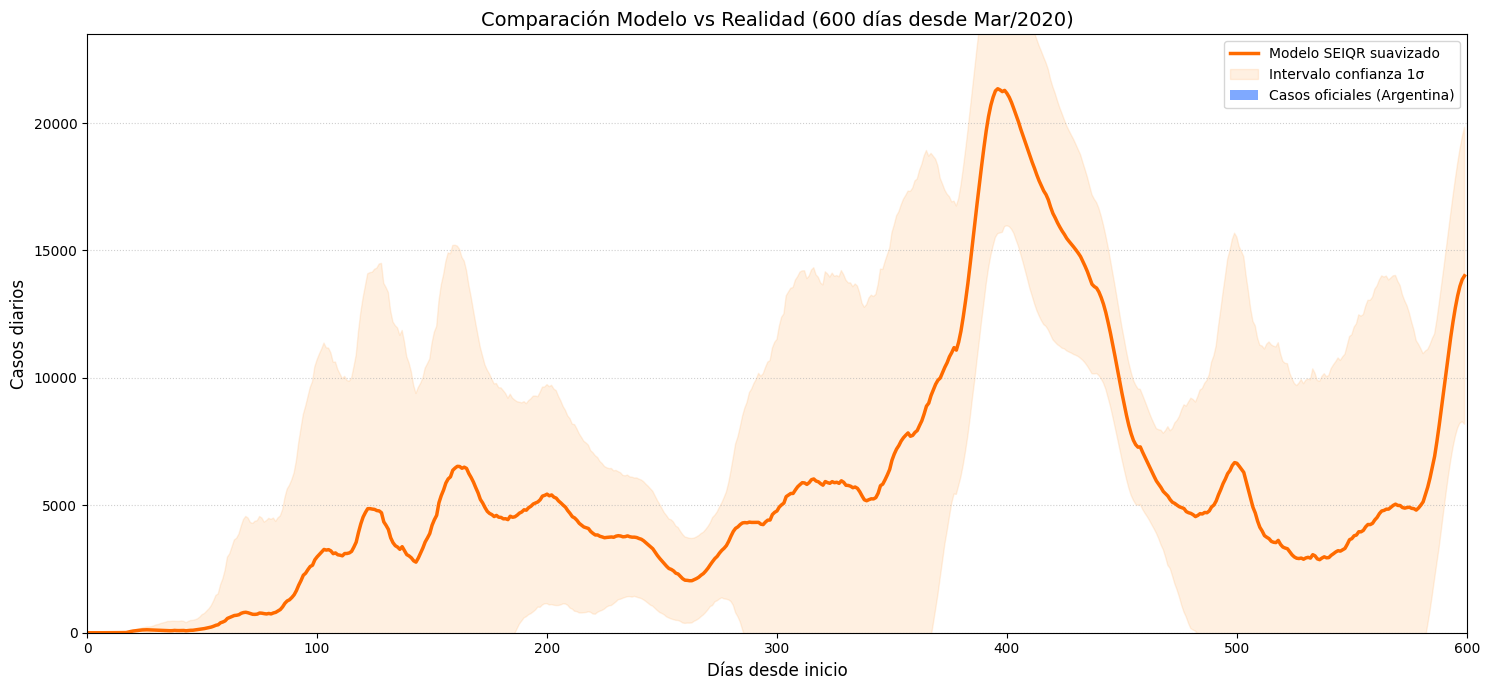

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.io import loadmat

# ====================== PARÁMETROS ======================
T = 600
ruta = '/content/code_seiqr_100T_600_yym_ARG.mat'

# ====================== CARGAR DATOS ======================
mat_data = loadmat(ruta)
yym = mat_data['serie']  # (600, 100) -> filas=días, columnas=simulaciones

# ====================== DATOS REALES ======================
# Si no tienes datos reales, podemos usar ceros
casos_oficiales = np.zeros(T)  # reemplazar con tus datos reales si los tienes

# ====================== PROMEDIO Y DESVIACIÓN ======================
mean_yym = np.mean(yym, axis=1)
std_yym = np.std(yym, axis=1)
days = np.arange(T)

# ====================== SUAVIZADO ======================
mean_yym_smooth = savgol_filter(mean_yym, window_length=21, polyorder=3)
std_yym_smooth = savgol_filter(std_yym, window_length=21, polyorder=3)

# ====================== GRAFICAR ======================
plt.figure(figsize=(15, 7))

# Curva simulada suavizada
plt.plot(days, mean_yym_smooth,
         label='Modelo SEIQR suavizado',
         color='#FF6B00',
         linewidth=2.5)

# Banda de desviación estándar
plt.fill_between(days,
                 mean_yym_smooth - std_yym_smooth,
                 mean_yym_smooth + std_yym_smooth,
                 color='#FF9E3B',
                 alpha=0.15,
                 label='Intervalo confianza 1σ')

# Casos oficiales
plt.bar(days, casos_oficiales,
        width=1.0,
        alpha=0.5,
        color='#0055FF',
        label='Casos oficiales (Argentina)')

# Ajustes estéticos
plt.title('Comparación Modelo vs Realidad (600 días desde Mar/2020)', fontsize=14)
plt.xlabel('Días desde inicio', fontsize=12)
plt.ylabel('Casos diarios', fontsize=12)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.xlim(0, T)
plt.ylim(0, max(mean_yym_smooth.max(), casos_oficiales.max()) * 1.1)

plt.tight_layout()
plt.show()
